## Capstone Project - The Battle of the Neighborhood

In [1]:
import time
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


## 1. Introduction:

I  recently moved to San Jose, California. Looking for afordable good neighboorhood to rent near downtown San Jose. he apartment in San Jose must meet the following demands:
apartment must be 2 or 3 bedrooms
desired location is near a rail or cal station and within 3.0 mile radius
price of rent not exceed $7,000 per month
top ammenities in the selected neighborhood shall be similar to current residence
desirable to have venues such as coffee shops,restaurants, gym and food shops

#### Business Problem 

The challenge is to find a suitable apartment for rent in San Jose California that complies with the demands on location, price and venues. The data required to resolve this challenge is described in the following section 2, below.

#### Insterested Audience

I believe this is a relevant challenge with valid questions for anyone moving to other large city. The methodology  is also applicable for anyone interested in exploring starting or locating a new business in any city. Lastly, it can also serve as a good practical exercise to develop Data Science skills.

### 2. Data Section

The following data is required to answer the issues of the problem:

- List of Boroughs and neighborhoods of San Jose with their geodata (latitude and longitude)
- List of rail and cal stations in San Jose with their address location
- List of apartments for rent in San Jose area with their addresses and price
- Preferably, a list of apartment for rent with additional information, such as price, address, area, # of beds, etc
- Venues for each San Jose neighborhood ( than can be clustered)
- Venues for rail stations, as needed

### Data Collection

The data of this project is gather from different sources and combined together for final exploraton and analysis: 

- Web Scrapping of apartment rent data from Craiglist.
- Light rail location 
- FourSquare API for gathering venues

Craiglist web scrapping provides neighboorhood name, number of bedroom, rent price and square feet of apartment.These data is used for exploratory data analysis. 
Fouresquare API will be used to source venues of ineterst. 


## Data Preparation(Web Scrapping data from Cariglist)

In [2]:
from selenium import webdriver
from bs4 import BeautifulSoup
import urllib
import re
import pandas as pd
import numpy as np


In [3]:
from requests import get

#get the first page of the east bay housing prices
response = get('https://sfbay.craigslist.org/search/sby/apa?hasPic=1) #get rid of those lame-o')#s that post a housing option without a pic using their filter
#response = get('https://sfbay.craigslist.org/pen/apa/d/san-mateo-beautiful-apartment-in-san/7047106962.html')

from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')

#get the macro-container for the housing posts
posts = html_soup.find_all('li', class_= 'result-row')
print(type(posts)) #to double check that I got a ResultSet
print(len(posts)) #to double check I got 120 (elements/page)

<class 'bs4.element.ResultSet'>
120


In [1]:
#grab the first post
post_one = posts[0]
post_one
index = 0
for post in posts:
    print(index, ": ", post)
    index += 1 

NameError: name 'posts' is not defined

In [5]:
post_one_price = post_one.a.text
post_one_price


'\n$2195\n'

In [6]:
#grab the time of the post in datetime format
post_one_time = post_one.find('time', class_ = 'result-date')
post_one_datetime = post_one_time['datetime']


In [7]:
#getting tile of post one
post1_title = post_one.find('a', class_ = 'result-title hdrlnk')
post1_link = post1_title['href']
post1_link

'https://sfbay.craigslist.org/sby/apa/d/san-jose-welcome-home-your-1-bedroom/7051723028.html'

In [8]:
post1_text = post1_title.text
post1_title.text

'Welcome home! Your 1 bedroom apt in Willow Glen, Totally RENOVATED!'

In [9]:
#getting post 1 neighboorhood
post1_neigh = post_one.find('span', class_ = 'result-hood').text
post1_neigh

' (willow glen / cambrian)'

In [10]:
post1_bed= post_one.find('span', class_ = 'housing').text
post1_bed1 = post1_bed.split()[0]
post1_bed1

post1_sqrt = post1_bed.split()[2][:-3]#cleans fit
post1_sqrt

'700'

In [11]:
#building loop
from time import sleep
from random import randint
from warnings import warn
from time import time
import numpy as np

In [12]:
#calculate total no. of post
tot_num = html_soup.find('div', class_ = 'search-legend')
result_tot = int(tot_num.find('span',class_ = 'totalcount').text)
result_tot

3000

In [13]:
#creating loop
pages = np.arange(0, result_tot,120)
iterations = 0
post_timing = []
post_neighs = []
post_title_texts = []
post_links =[]
post_prices = []
bed_counts=[]
sqfits=[]

for page in pages:
    response = get ("https://sfbay.craigslist.org/search/sby/apa?"
                    +"s="
                    +str(page)
                    +"&hasPic=1")
    sleep(randint(1,5))
    
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
    
    #define html text
    page_html = html_soup.find_all('li', class_ = 'result-row')
    
    #define the post
    posts = html_soup.find_all('li', class_ = 'result-row')
    
    #extract each item data
    for post in posts:
        if post.find('span', class_ = 'result-hood') is not None:
            #neighborhoods
            post_neigh = post.find('span', class_= 'result-hood').text
            post_neighs.append(post_neigh)
            
            #title text
            post_title = post.find('a', class_ = 'result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)
            
            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            #post price
            post_price = post.a.text
            post_prices.append(post_price)
            
            #remove whitespaces, $ sign and turns it into int
            post_price=int(post.a.text.strip().replace("$",""))
            post_prices.append(post_price)
            
        #bedroom extract
        if post.find('span', class_ = 'housing') is not None:
            #is first element is sqft
            if 'sqft' in post.find('span', class_ = 'housing').text.split()[0]:
                #bedroom value will be nan
                bed_count = np.nan
                bed_counts.append(bed_count)
                
                #sqft will be first element
                sqfit = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                sqfits.append(sqfit)
                
            #if lent of text is more that 2
            elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                
                # first element will be bedroom
                bed_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                bed_counts.append(bed_count)
                
                #second element will be sqft
                sqfit = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                sqfits.append(sqfit)
                
            #if htere is bedroom but no sqft
            elif len(post.find('span', class_='housing').text.split()) == 2:
                #0 will be bedroom
                bed_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                bed_counts.append(bed_count)
                 
                #next wiil be sqft
                sqfit = np.nan
                sqfits.append(sqfit)
                
            #if non of those condition match:
            else:
                bed_count = np.nan
                bed_counts.append(bed_count)
                
                sqfit=np.nan
                sqfits.append(sqfit)
                
            #post_bed_count = post.find('span', class_ = 'housing').text.split()[]
            
    
    iterations += 1
    print("Page " + str(iterations) + " scraped successfully!")
 
print("\n")

print("Scrape complete!")   

Page 1 scraped successfully!
Page 2 scraped successfully!
Page 3 scraped successfully!
Page 4 scraped successfully!
Page 5 scraped successfully!
Page 6 scraped successfully!
Page 7 scraped successfully!
Page 8 scraped successfully!
Page 9 scraped successfully!
Page 10 scraped successfully!
Page 11 scraped successfully!
Page 12 scraped successfully!
Page 13 scraped successfully!
Page 14 scraped successfully!
Page 15 scraped successfully!
Page 16 scraped successfully!
Page 17 scraped successfully!
Page 18 scraped successfully!
Page 19 scraped successfully!
Page 20 scraped successfully!
Page 21 scraped successfully!
Page 22 scraped successfully!
Page 23 scraped successfully!
Page 24 scraped successfully!
Page 25 scraped successfully!


Scrape complete!


In [14]:
import pandas as pd
# apt = pd.DataFrame({'neighborhood' : post_neighs,
#                   'post title' : post_title_texts,
#                    'number bedrooms': bed_counts,
#                    'sqft' : sqfits,
#                      'URL': post_links,
#                      'price': post_prices}
#                  )

apt = {'neighborhood' : post_neighs,
                   'post title' : post_title_texts,
                   'number bedrooms': bed_counts,
                 'sqft' : sqfits,
                   'URL': post_links,
                   'price': post_prices}

print(len(post_neighs),len(post_title_texts),len(bed_counts),len(sqfits),len(post_links),len(post_prices))
apt_fi = pd.DataFrame.from_dict(apt,orient='index')
apt1=apt_fi.transpose()
apt1.to_csv('parsed.csv',index=False)
# writer=pd.ExcelWriter(r'output.xlsx')
# apt_fi.to_excel(writer,sheet_name='cx')
# writer.save()
#apt_fi.transpose()
#print(apt_fi.info())
#apt_fi.head()
# k=list(apt.keys())
# v=list(apt.values())
# df=pd.DataFrame(list(zip(k,v)),columns=['k','v'])
# df


2900 2900 2975 2975 2900 5800


### Data Cleaning

In [6]:
import pandas as pd
apt2 = pd.read_csv('/Users/bnakarmi/Documents/coursera/CapStone Project copy/export_dataframe1.csv')
#apt2 = apt.to_csv(r'export_dataframe.csv', index = None, header = True)
apt2.head()
apt3=pd.DataFrame(apt2)
apt3.head()

,neighborhood,post title,number bedrooms,sqft,URL,price,lat,long
0,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990.0,37.3230,-122.0322
1,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990.0,37.3230,-122.0322
2,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990.0,37.3230,-122.0322
3,milpitas,"Pool And Spa with Fireside Lounge, Outdoor BBQ...",1,785.0,https://sfbay.craigslist.org/sby/apa/d/milpita...,2455.0,37.4323,-121.8996
4,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990.0,37.3230,-122.0322


In [7]:
#apt3['price'] = apt3['price'].apply(lambda x: re.sub(r'[\n$]+', '', x))
#apt3['price'].replace('', np.nan, inplace = True)
#convert price into url
apt3['price'] = apt3['price'].astype(int)
apt3.head()

,neighborhood,post title,number bedrooms,sqft,URL,price,lat,long
0,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.3230,-122.0322
1,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.3230,-122.0322
2,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.3230,-122.0322
3,milpitas,"Pool And Spa with Fireside Lounge, Outdoor BBQ...",1,785.0,https://sfbay.craigslist.org/sby/apa/d/milpita...,2455,37.4323,-121.8996
4,cupertino,"NEW UNIT, PRIME LOCATION, NEXT TO VTA/GROCERY....",2,800.0,https://sfbay.craigslist.org/sby/apa/d/cuperti...,2990,37.3230,-122.0322


In [69]:
#drop NA
apt_cl = apt3.dropna()

In [70]:
#remove()
apt_cl['neighborhood'] = apt_cl['neighborhood'].apply(lambda x: re.sub(r'[()]+', '', x))

#remove /
apt_cl['neighborhood'] = apt_cl['neighborhood'].apply(lambda x: re.sub(r'[/]+', '', x))

# remove ,
apt_cl['neighborhood'] = apt_cl['neighborhood'].apply(lambda x: re.sub(r'[,]+', '', x))

apt_cl['neighborhood'] = apt_cl['neighborhood'].apply(lambda x: x.lstrip(' '))

/Users/bnakarmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/bnakarmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/bnakarmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

In [71]:
#get unique url
apt_cl = apt_cl.drop_duplicates(subset="URL")

In [72]:
apt_cl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 108
Data columns (total 8 columns):
neighborhood       98 non-null object
post title         98 non-null object
number bedrooms    98 non-null int64
sqft               98 non-null float64
URL                98 non-null object
price              98 non-null int64
lat                98 non-null float64
long               98 non-null float64
dtypes: float64(3), int64(2), object(3)
memory usage: 6.9+ KB


In [73]:
apt_cl.tail()

,neighborhood,post title,number bedrooms,sqft,URL,price,lat,long
103,mountain view,"Designer Quartz Countertops, Chef-inspired Kit...",2,1600.0,https://sfbay.craigslist.org/sby/apa/d/palo-al...,3075,37.3861,-122.0839
105,mountain view,"Mountain View 3BR apt, Very spacious! Modern f...",2,982.0,https://sfbay.craigslist.org/sby/apa/d/los-alt...,3895,37.3861,-122.0839
106,san jose west,Upgraded 1bed/1bath - Menden Manor Apartments,1,453.0,https://sfbay.craigslist.org/sby/apa/d/san-jos...,1995,337.3020,-121.9970
107,san jose south,Apartment for rent,2,971.0,https://sfbay.craigslist.org/sby/apa/d/san-jos...,2300,37.2802,-121.8362
108,san jose downtown,"Excellent value! San Jose 1 bedroom apt, High ...",2,1155.0,https://sfbay.craigslist.org/sby/apa/d/san-jos...,2099,37.3337,-121.8907


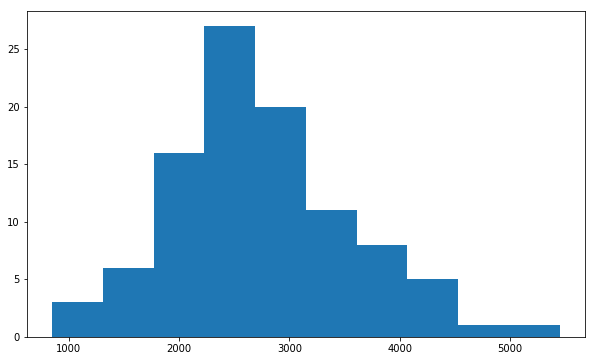

In [74]:
#check distribution of price
from matplotlib import figure 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize = (10,6))
plt.hist(apt_cl['price']);


In [75]:
#export_csv = apt.to_csv(r'\\Users\bnakarmi\Documents\export_dataframe.csv', index = None, header = True)
export_csv = apt_cl.to_csv(r'export_dataframe.csv', index = None, header = True)

In [76]:
def f(row):
    if row['neighborhood'] == 'cupertino':
        val = '37.3230,-122.0322'
        
    elif row['neighborhood'] == 'milpitas':
        val = '37.4323,-121.8996'
        
    elif row['neighborhood'] == 'san jose west':
        val = '337.3020,-121.9970'
    
    elif row['neighborhood'] == 'san jose east':
        val = '37.3262,-121.8202'
    
    elif row['neighborhood'] == 'san jose downtown':
        val = '37.3337,-121.8907'
    
    elif row['neighborhood'] == 'sunnyvale':
        val = '37.3688,-122.0363'
        
    elif row['neighborhood'] == 'santa clara':
        val = '37.3541,-121.9552'
    elif row['neighborhood'] == 'campbell':
        val = '37.2872,-121.9500'
    elif row['neighborhood'] == 'san jose north':
        val = '37.3897,-121.9302'
    elif row['neighborhood'] == 'san jose south':
        val = '37.2802,-121.8362'
    elif row['neighborhood'] == 'mountain view':
        val = '37.3861,-122.0839'
    elif row['neighborhood'] == 'los gatos':
        val = '37.2358,-1121.9624'
        
    else:
        val = 0
        
    return val
    

In [8]:
#adding new lat long column
apt_cl['lat'] = apt_cl.apply(f,axis=1)

#splitting lat long column into two
#apt_cl1 = apt_cl.drop(['lat', 'lat_long'], axis =1)
#apt_cl1

NameError: name 'apt_cl' is not defined

In [84]:
apt_cl[['lat','long']]= apt_cl['lat'].str.split(',',expand=True)

In [3]:
#dropping null values
apt_cl.dropna(how='any')

NameError: name 'apt_cl' is not defined

In [78]:

final_apt = apt_cl.to_csv(r'final_dataframe1.csv', index = None, header = True)

## Mapping of San Jose, California

In [134]:
import time
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [135]:
address = 'Downtown San Jose, California'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of San Jose home are {}, {}.'.format(latitude, longitude))

/Users/bnakarmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of San Jose home are 37.3359104, -121.8910758.


## Exploratory Data Analysis

In [87]:
apt_cl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 108
Data columns (total 8 columns):
neighborhood       98 non-null object
post title         98 non-null object
number bedrooms    98 non-null int64
sqft               98 non-null float64
URL                98 non-null object
price              98 non-null int64
lat                98 non-null object
long               98 non-null object
dtypes: float64(1), int64(2), object(5)
memory usage: 6.9+ KB


In [10]:
#pd.options.display.max_colwidth = 100
#filetering apt price value
apt_cl[(apt_cl['price'] < 7000) & (apt_cl['price'] > 2000)]

NameError: name 'apt_cl' is not defined

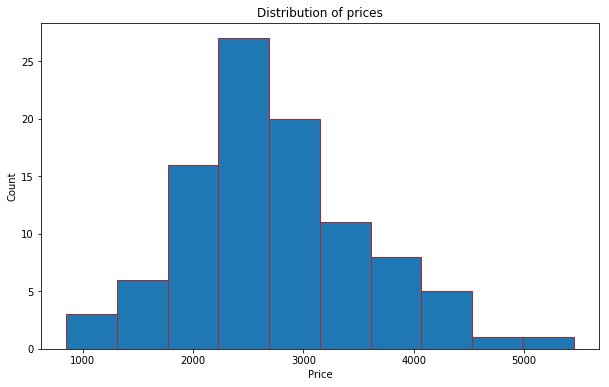

In [88]:
#look for price distribution
from matplotlib import figure
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
plt.hist(apt_cl['price'], edgecolor = 'brown');
plt.xlabel("Price")
plt.ylabel('Count')
plt.title("Distribution of prices");

In [89]:
#grouping city and finding mean for no. of bed room, price, sqft
apt_cl.groupby('neighborhood').mean()


,number bedrooms,sqft,price
neighborhood,,,
campbell,2.500000,1184.833333,2700.000000
cupertino,1.818182,901.909091,2956.818182
los gatos,1.000000,400.000000,3390.000000
milpitas,1.700000,896.500000,3121.000000
mountain view,2.333333,1235.166667,3415.833333
san jose downtown,1.571429,946.523810,2394.142857
san jose north,3.000000,1500.000000,3800.000000
san jose south,1.571429,886.428571,2473.142857
san jose west,1.909091,901.363636,2400.909091


In [90]:
apt_sort = pd.DataFrame(apt_cl.groupby('neighborhood').mean()['price'].sort_values())
apt_sort

,price
neighborhood,
santa clara,2265.384615
san jose downtown,2394.142857
san jose west,2400.909091
san jose south,2473.142857
campbell,2700.000000
cupertino,2956.818182
milpitas,3121.000000
sunnyvale,3218.181818
los gatos,3390.000000


In [118]:
#### Normalization of data
from sklearn.preprocessing import scale

apt_dp = apt_cl[['number bedrooms','sqft','price']]
                
apt_scale = scale(apt_dp)
apt_scale
#convert into dataframe
apt_df = pd.DataFrame(apt_scale)
apt_df.columns = ['number bedrooms','sqft','price']
apt_df.head()


/Users/bnakarmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


,number bedrooms,sqft,price
0,0.133432,-0.389577,0.320507
1,0.133432,-0.389577,0.320507
2,0.133432,-0.389577,0.320507
3,-0.956264,-0.421982,-0.312395
4,0.133432,-0.389577,0.320507


##### Price vs square foot 

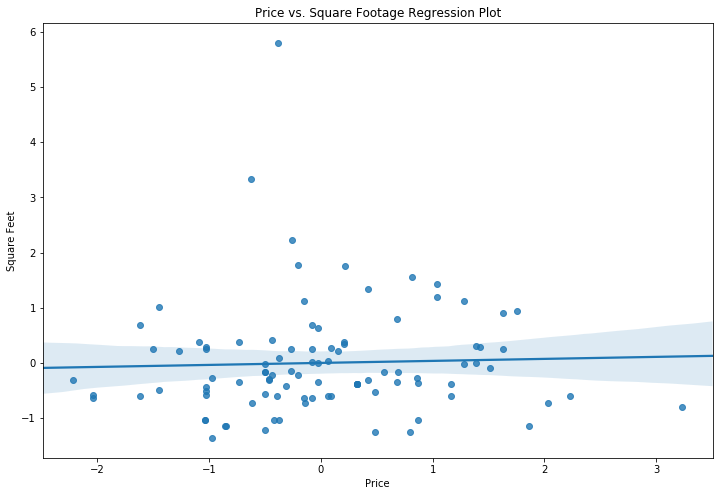

In [119]:
plt.figure(figsize=(12,8))
sns.regplot(x='price', y = 'sqft', data = apt_df);
plt.title('Price vs. Square Footage Regression Plot');
plt.xlabel("Price");
plt.ylabel("Square Feet");

In [121]:
apt_df.corr()

,number bedrooms,sqft,price
number bedrooms,1.000000,0.875274,0.045696
sqft,0.875274,1.000000,0.036451
price,0.045696,0.036451,1.000000


In [125]:
apt_cl.describe()

,number bedrooms,sqft,price
count,98.000000,98.000000,98.000000
mean,1.877551,980.336735,2719.071429
std,0.922405,465.283528,849.658552
min,1.000000,350.000000,850.000000
25%,1.000000,702.750000,2223.750000
50%,2.000000,862.500000,2650.000000
75%,2.000000,1114.750000,3271.250000
max,7.000000,3667.000000,5450.000000


#### Prices by neighboorhood box plot


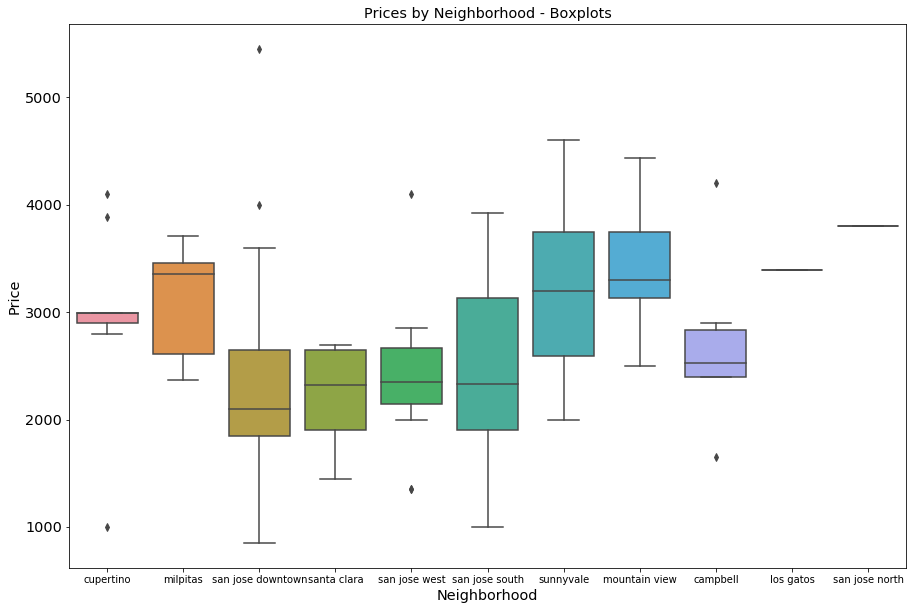

In [133]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15,10))

lbl = {'legend.fontsize': 'x-large',
      'figure.figsize': (15,5),
      'axes.labelsize':'x-large',
      'axes.titlesize':'x-large',
      'ytick.labelsize':'x-large'}
plt.rcParams.update(lbl)

sns.boxplot(x='neighborhood', y='price', data = apt_cl)
plt.xlabel("Neighborhood");
plt.ylabel("Price")
plt.title("Prices by Neighborhood - Boxplots");